In [20]:
%load_ext autoreload
%autoreload 2

import sys, h5py, numpy as np, scipy.stats, healpy as hp, tqdm

%matplotlib inline
import matplotlib.pyplot as plt, matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
#mpl.rcParams['figure.figsize'] = (6, 4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
eps=1e-10

lmax = 50
lengthscale = 0.3

M_bins = np.arange(10,21.1,1)
M = M_bins.shape[0]-1
C = 1
nside=32
nside_original = 128
resize = int((nside_original/nside)**2+0.1)

In [68]:
box={}; nside_original = 128
box['n']=np.zeros((M, C, hp.nside2npix(nside)), dtype=np.int)
box['k']=np.zeros((M, C, hp.nside2npix(nside)), dtype=np.int)
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_hpx10.h', 'r') as hf:
    for i, mag in tqdm.notebook.tqdm(enumerate(hf['magval']), total=len(hf['magval'])):
        if (mag+eps<M_bins[0])|(mag+eps>M_bins[-1]): continue
        hpx = hf[str(i)]['hpx'][...]//resize
        M_idx = np.sum(M_bins<mag+eps).astype(int) - 1
        box['n'][M_idx,0] = scipy.stats.binned_statistic(hpx, hf[str(i)]['n'][...],
                                                     bins=np.arange(hp.nside2npix(nside)+1)-0.5, 
                                                     statistic='sum').statistic.astype(int)
        box['k'][M_idx,0] = scipy.stats.binned_statistic(hpx, hf[str(i)]['k_ast'][...],
                                                     bins=np.arange(hp.nside2npix(nside)+1)-0.5, 
                                                     statistic='sum').statistic.astype(int)
        
lengthscale_m = lengthscale/(M_bins[1]-M_bins[0])
lengthscale_c = 1.

  0%|          | 0/213 [00:00<?, ?it/s]

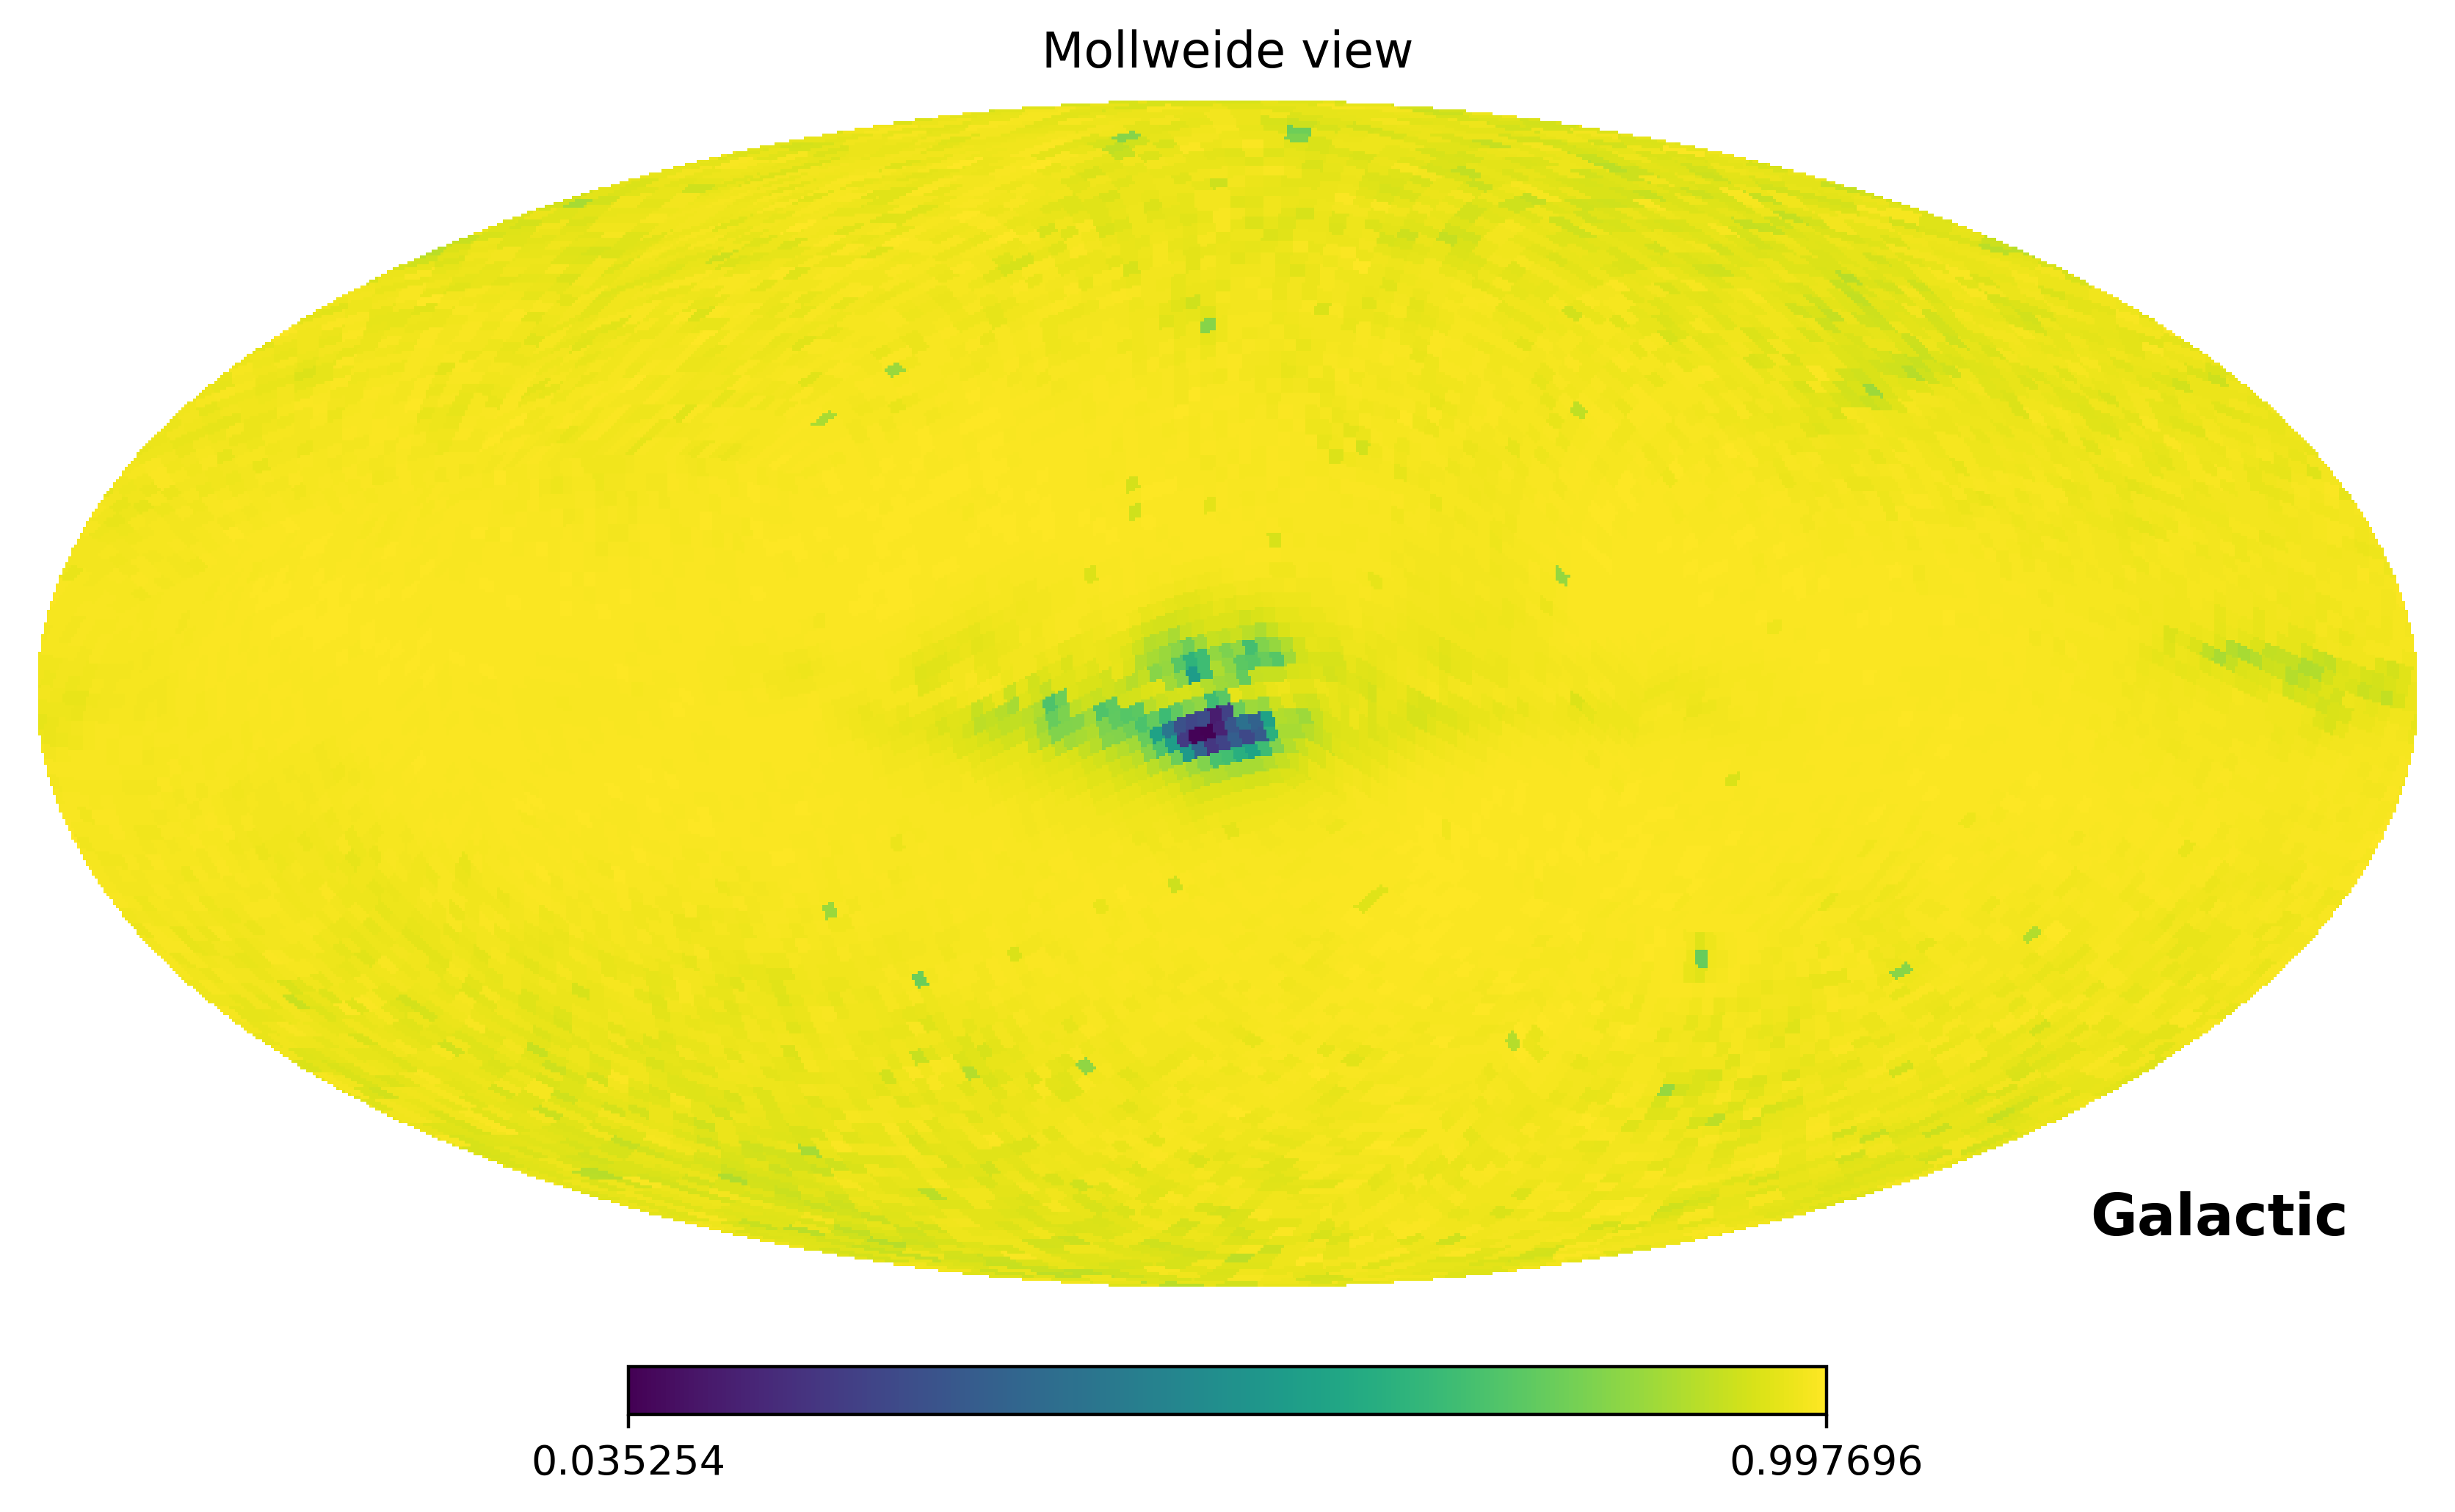

In [74]:
hp.mollview((box['k'][9,0]+1)/(box['n'][9,0]+2), nest=True, coord=['C','G'])

In [70]:
# Import hammer
from SelectionFunctionHammer import Hammer

In [71]:
hammer = Hammer(k = box['k'],
                n = box['n'],
                axes = ['magnitude','colour','position'],
                nest = True,
                lmax = lmax,
                lengthscale_m = lengthscale_m,
                lengthscale_c = lengthscale_c,
                M = M,
                C = C,
                nside = nside,
                sparse = True,
                pivot = True,
                mu = 0.0,
                sigma = [1.32824171, -2.97102361],
                file_root = f"lmax{lmax}_nside{nside}_M{M}_C{C}_l{lengthscale}",
                )

  1%|          | 27/2601 [00:00<00:09, 269.50it/s]

Spherical harmonic file does not exist, generating...


100%|██████████| 2601/2601 [00:08<00:00, 317.95it/s]
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/andy/Documents/Research/Projects/EDR3_selection/astrometry/SelectionFunctionHammer/StanModels/magnitude_colour_position_sparse


Spherical harmonic file loaded
82.64% sparsity
0.00% sparsity


In [72]:
# Run hammer
hammer.optimize(number_of_iterations = 10000)

Running optimisation


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


Finished optimisation, it took 401.1 seconds
Convergence information stored in ./StanOutput/lmax50_nside32_M11_C1_l0.3_convergence.txt
Optimum values stored in ./StanOutput/lmax50_nside32_M11_C1_l0.3_results.h5


In [52]:
# Print convergence information
hammer.print_convergence(number_of_lines = 10)

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

     899   -3.2516e+07      0.154257       270.549           1           1      990   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

     999  -3.25159e+07     0.0288948       304.364           1           1     1095   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    1099  -3.25159e+07    0.00796429       107.163           1           1     1206   

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

    1101  -3.25159e+07    0.00474318       105.387      0.7974      0.7974     1208   

Optimization terminated normally: 

  Convergence detected: relative gradient magnitude is below tolerance



In [77]:
hammer.stan_output_directory, hammer.file_root

('./StanOutput/', 'lmax50_nside32_M11_C1_l0.3')

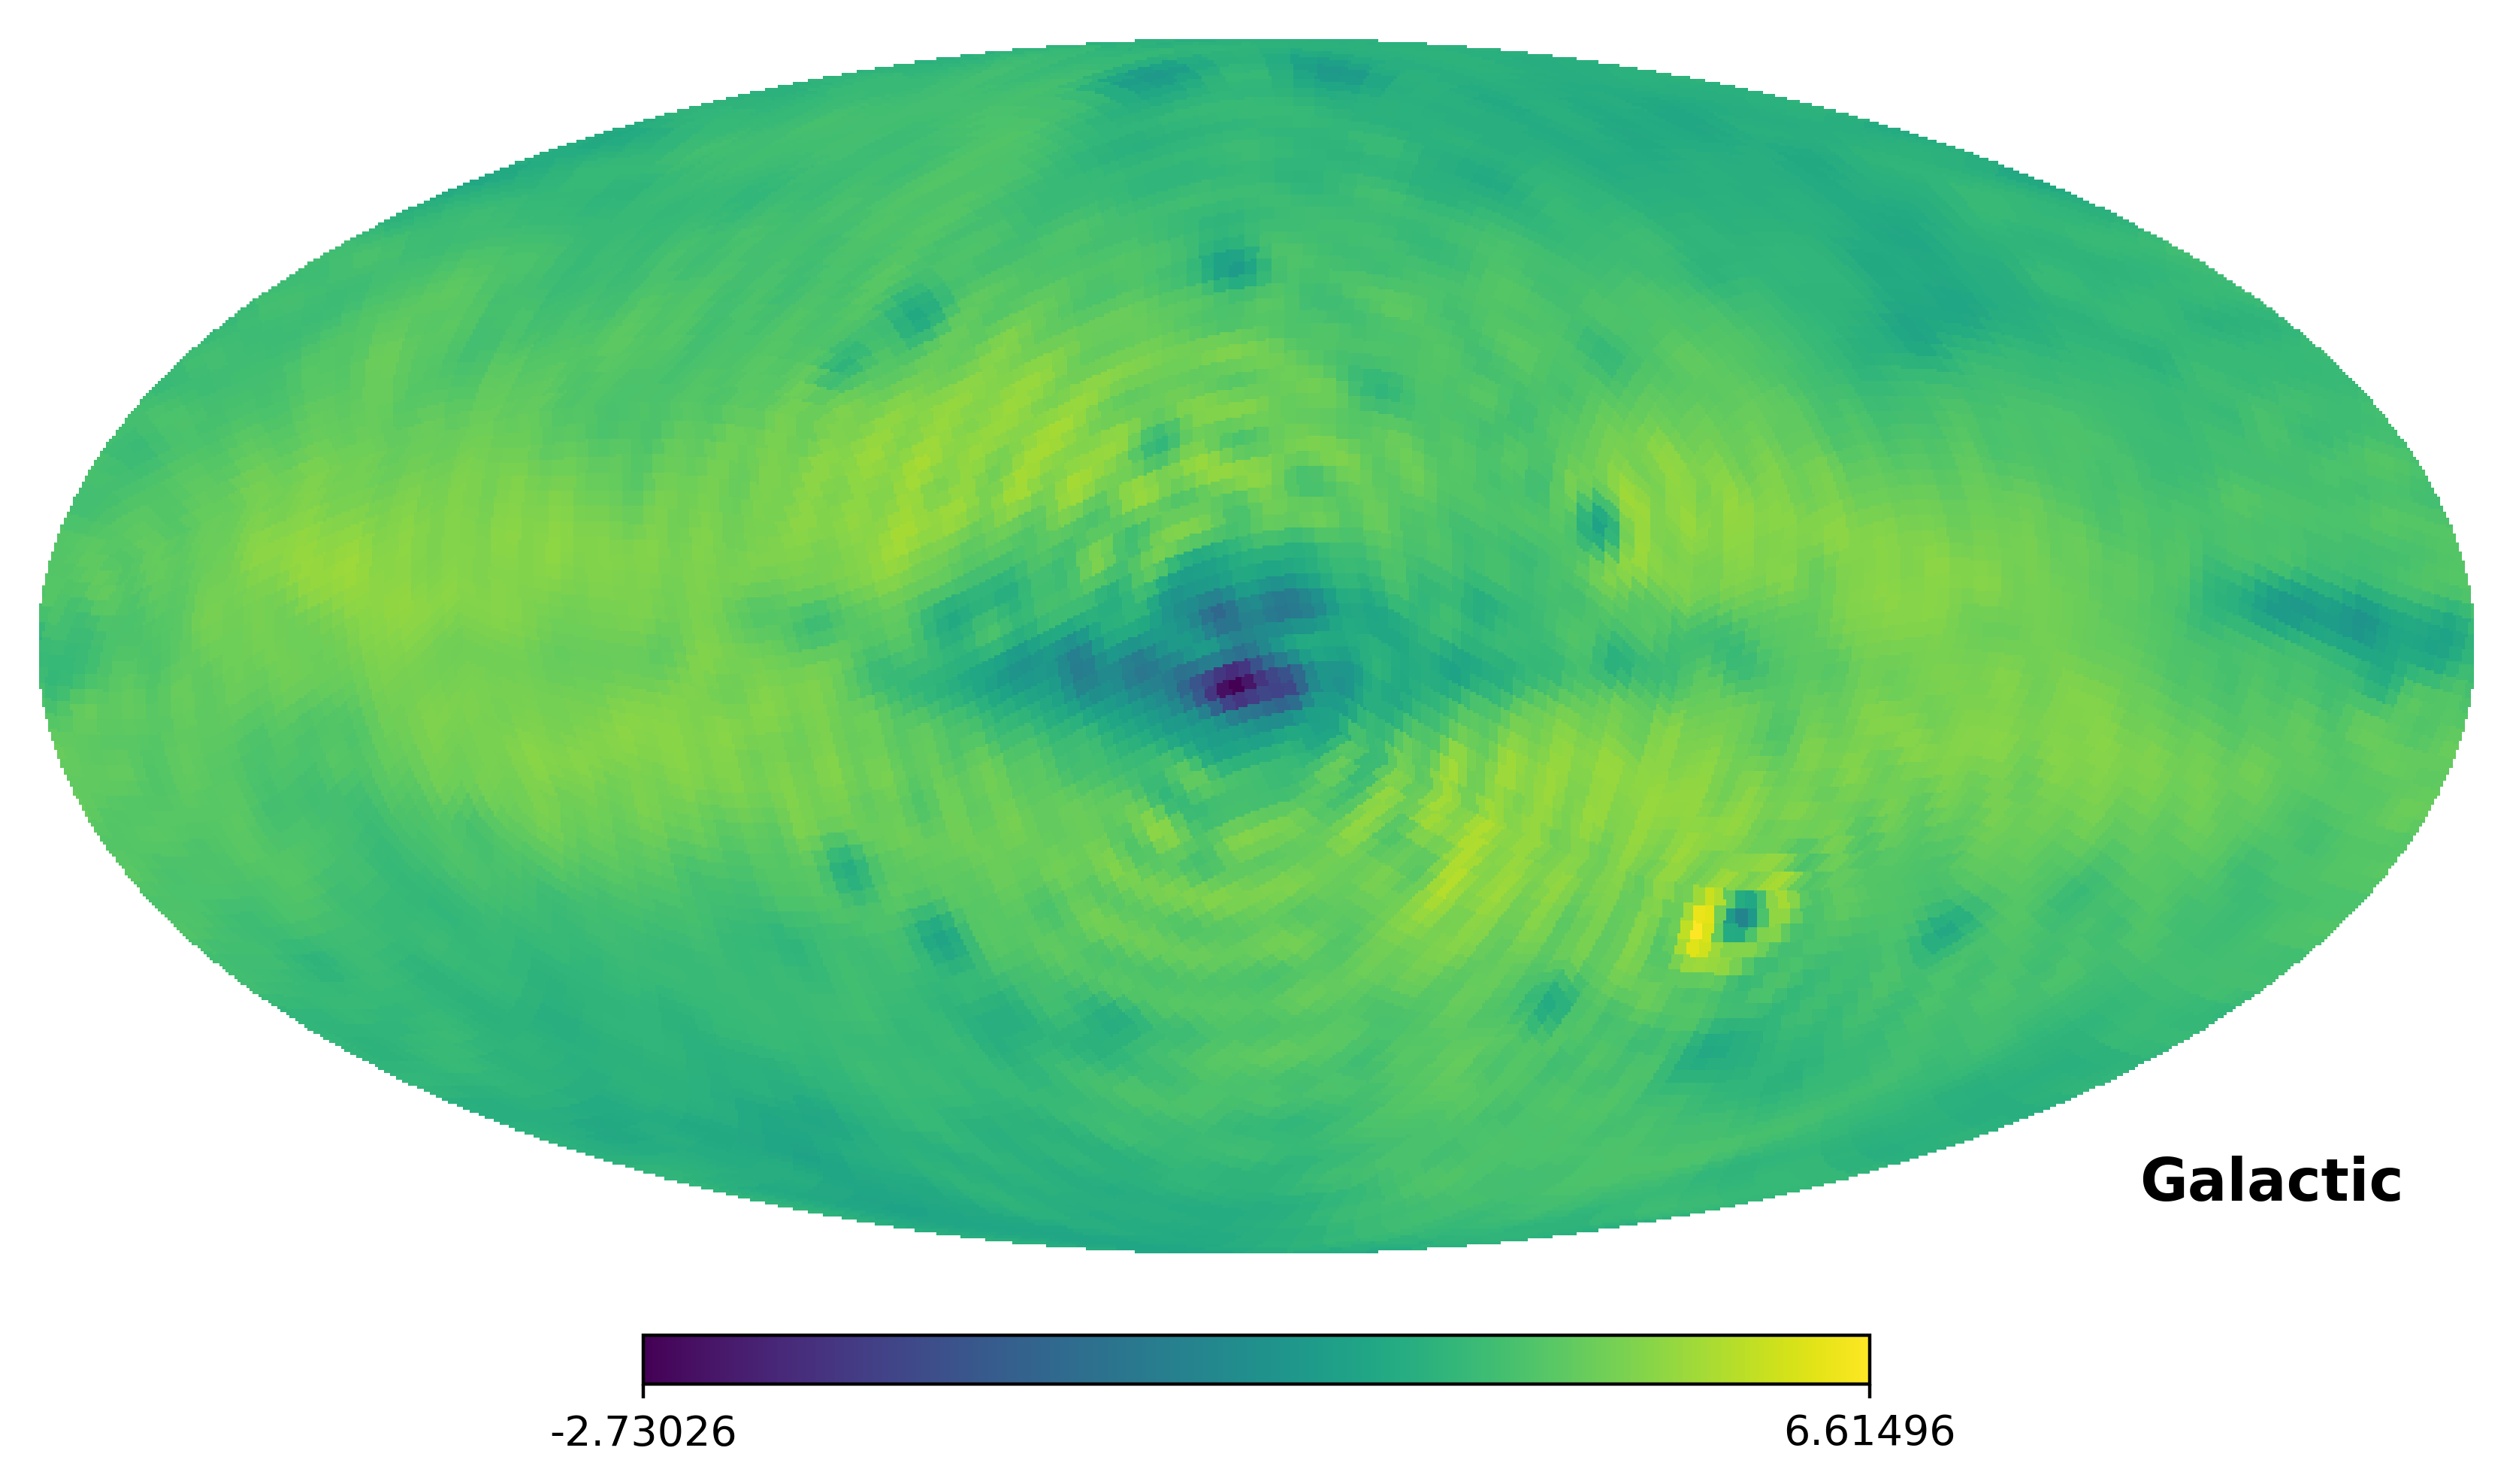

In [75]:
hp.mollview(hammer.optimum_x[9,0],nest=True,coord=['C','G'], title='')

In [91]:
result = {}
with h5py.File('StanOutput/lmax50_nside16_M11_C1_l0.3_results.h5', 'r') as hf:
    result = {k:v[...] for k,v in hf.items()}

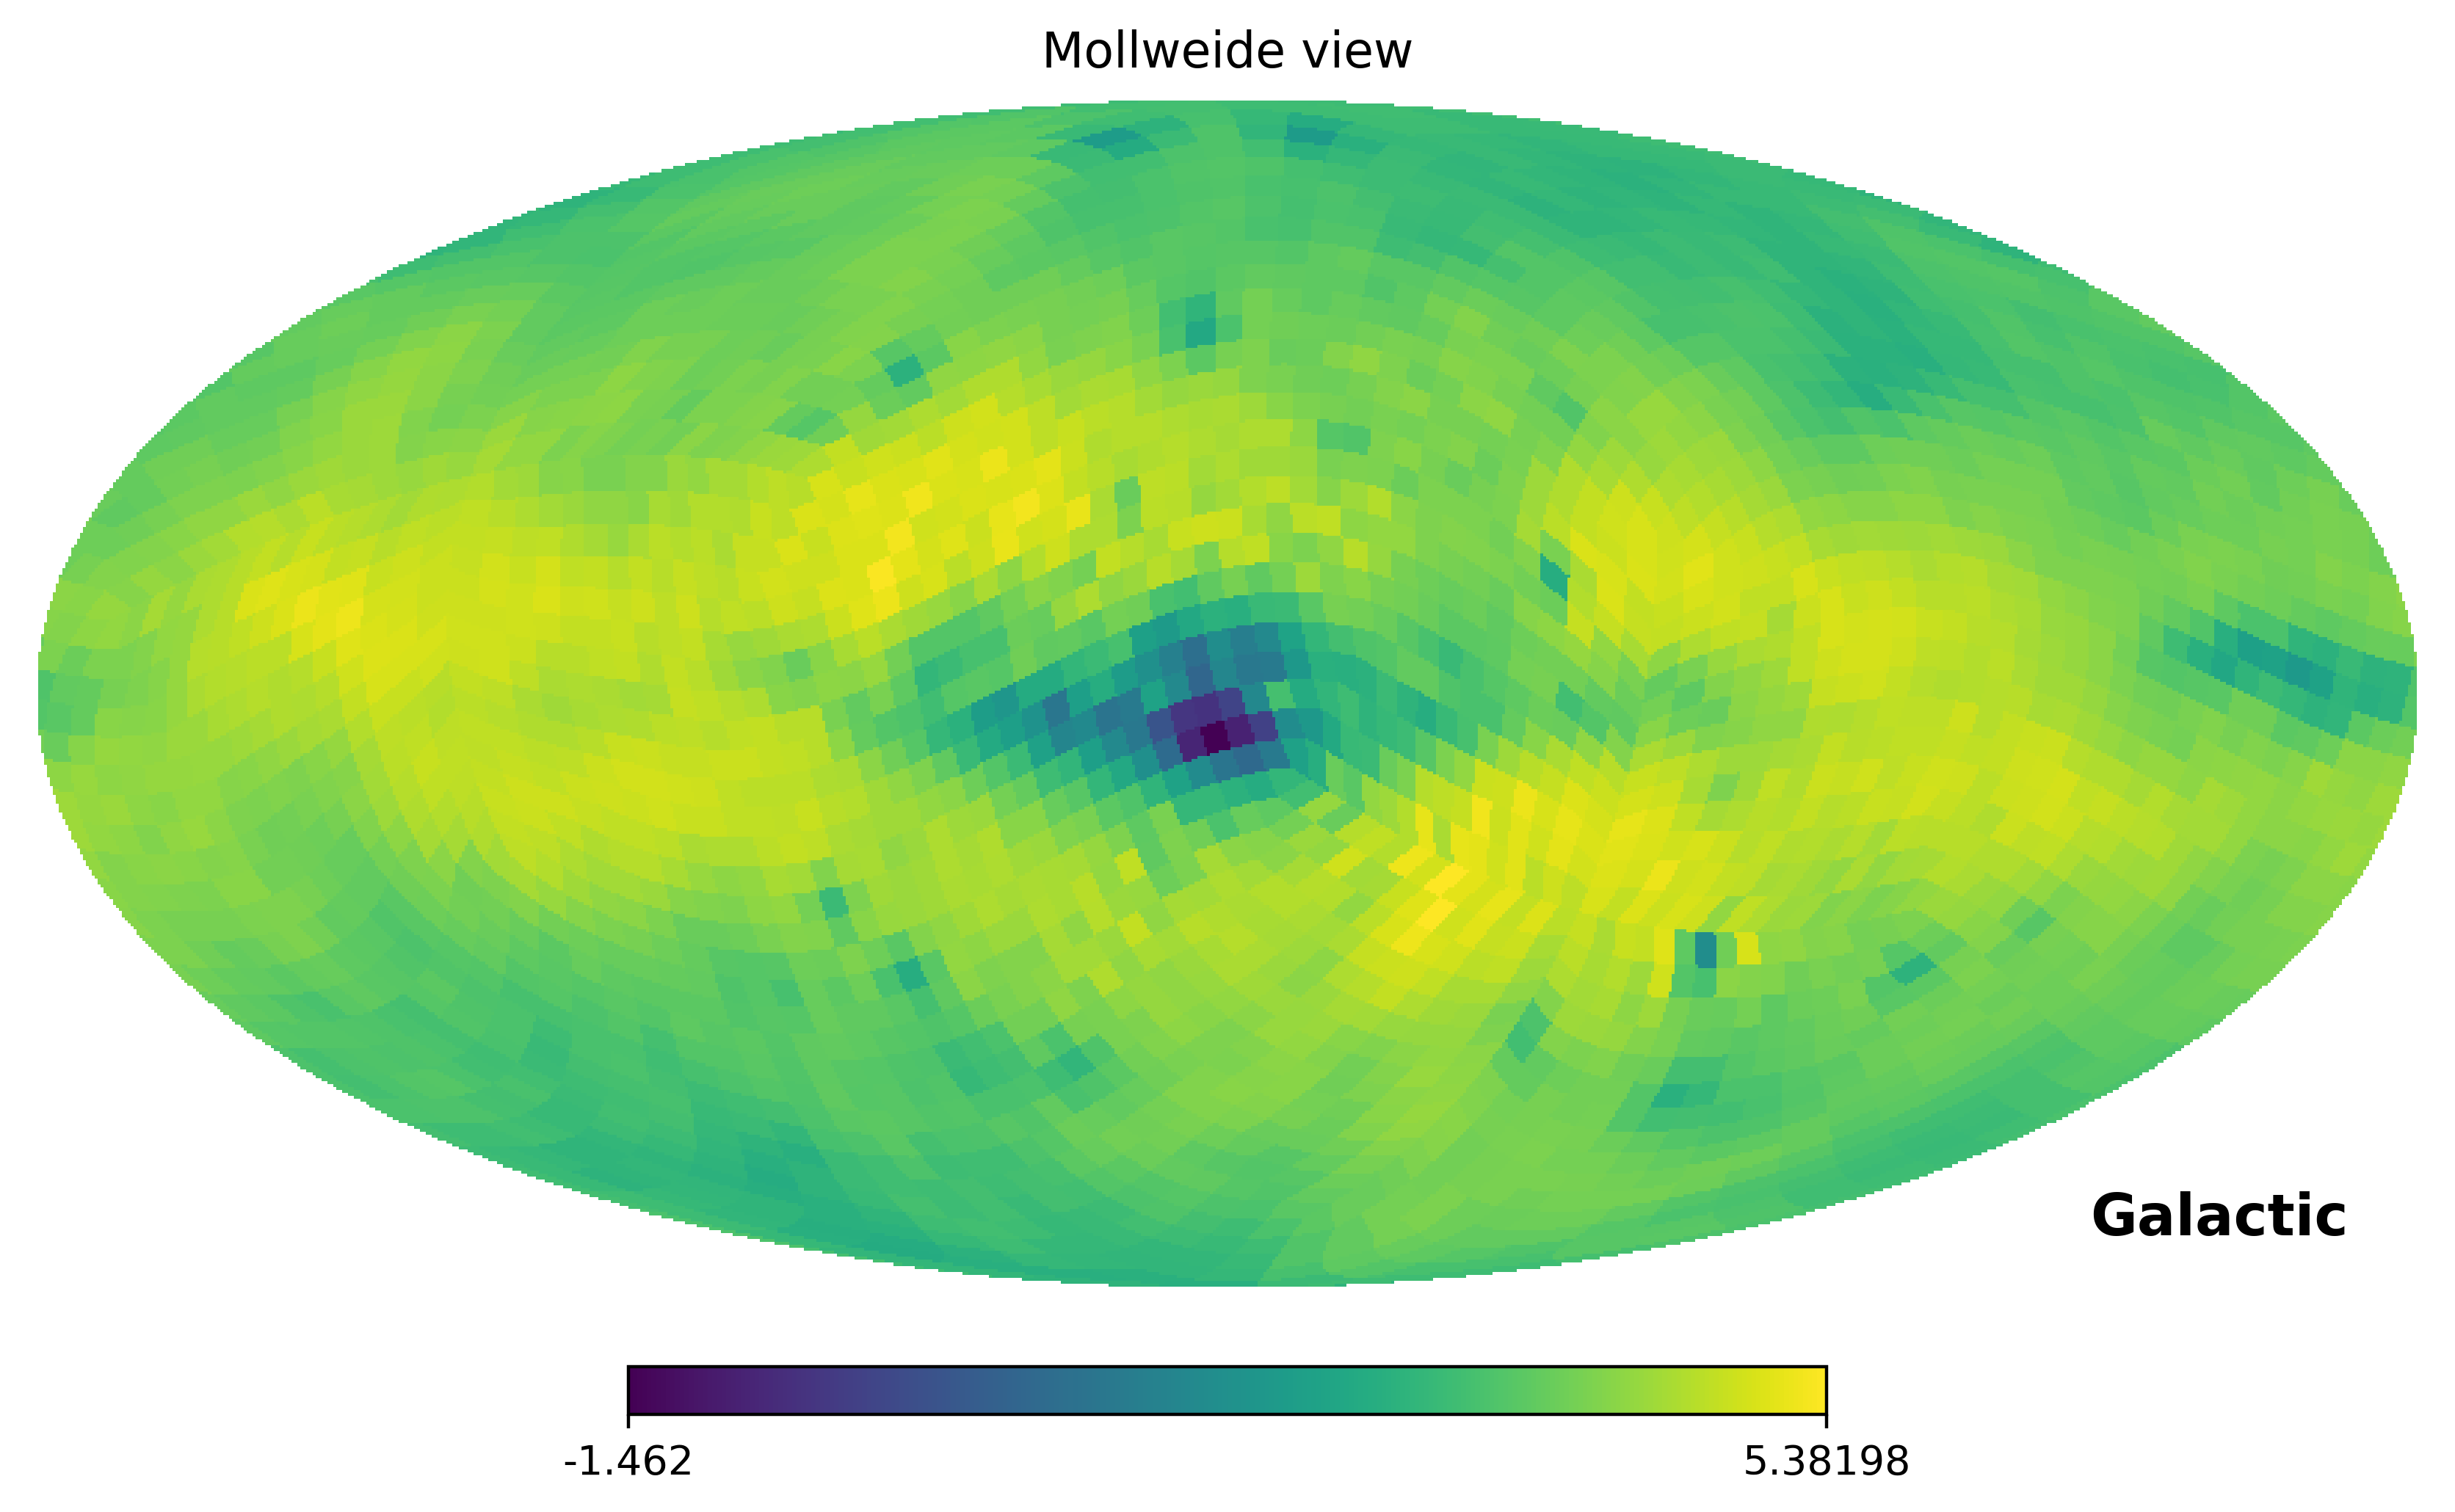

In [96]:
hp.mollview(result['x'][9,0],nest=True,coord=['C','G'],cmap='viridis')

In [99]:
result['z'].shape

(2601, 11, 1)